In [9]:
from langchain_groq import ChatGroq
from dotenv import load_dotenv

load_dotenv()
llm = ChatGroq(model="llama-3.3-70b-versatile")

In [178]:
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, AIMessage, SystemMessage, BaseMessage
from langgraph.graph.message import add_messages
from pydantic import BaseModel, Field
from typing import Annotated, Literal
import json
import re

class CustomBaseModel(BaseModel):
    @classmethod
    def get_json_schema(cls) -> str: 
        return json.dumps(cls.model_json_schema()["properties"])


class Goal(CustomBaseModel):
    name: str = Field("Name of the goal that user is trying to achieve")
    amount: float = Field("Amount that user is trying to save for the given goal")

class UserProfile(CustomBaseModel):
    income: float = Field(description="monthly income")
    expenses: float = Field(description="monthly expenses")
    tolerance: Literal["low", "medium", "high"] = Field(description="Risk tolerance")
    preferences: list[str] = Field(default=[], description="A list of user's preferences where they'd like to invest.")
    goals: list[Goal] = Field(default=[], description="A list of goals that user is trying to achieve by investing")
    

In [190]:
def extract_content_from_tags(tag_name, txt: str):
    match = re.search(f"<{tag_name}>(.*?)</{tag_name}>", txt, re.DOTALL)
    return match[1]


In [179]:
class SharedState(BaseModel):
    question: str
    messages: Annotated[list[BaseMessage], add_messages] = Field(default=[])
    user_profile: UserProfile = Field(default=None, description="contains information regarding User's income/expenses/their risk tolerance etc.")

In [73]:
test_json = {
    "income": 5000,
    "expenses": 3000,
    "tolerance": "medium",
}

In [196]:
def collect_user_profile(state: SharedState):
    prompt_template = """
    You are a financial assistant. Your task is to extract a user's financial profile from their message, strictlyt following the provided JSON schema.

    Instructions:
    1. Use the JSON schema provided in <schema></schema> as an example to determine which fields to extract, their types, and any default values.
    2. If a field is missing in the user's input but has a default in the schema use that default.
        - If the field is mandatory and missing, fill it with a sensible placeholder (e.g., 0 for numbers, empty list for arrays, "medium" for risk_tolerance).

    3. only include fields defined in the schema.
    4. output valid JSON
    5. Do not add any extra fields


    <schema>
    %s
    </schema>

    This is the input example:
    "I earn 5000$ per month and I spend 3000$. I want to save 2000$ for a vacation."

    Example of expected JSON output(wrap the JSON within <generated_json></generated_json> tags):
    {
        "income": 5000,
        "expenses": 3000,
        "tolerance": "medium",
        "preferences": [],
        "goals: [{"name": "vacation", "amount": 2000}]
    }
    """
    system_message = SystemMessage(prompt_template % UserProfile.get_json_schema())
    human_message = HumanMessage(state.question)

    system_message.pretty_print()
    
    llm_response = llm.invoke([system_message, human_message])
    extracted_content = extract_content_from_tags("generated_json", llm_response.content)
    extracted_json = json.loads(extracted_content)
    user_profile = UserProfile(**extracted_json)
    print("User profile", user_profile)
    

    state.messages = [human_message, llm_response]
    return state

def second_state(state: SharedState):
    for m in state.messages:
        m.pretty_print()

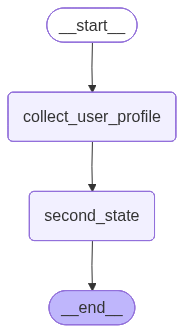

In [197]:
builder = StateGraph(SharedState)
builder.add_node(collect_user_profile)
builder.add_node(second_state)

builder.set_entry_point("collect_user_profile")
builder.add_edge("collect_user_profile", "second_state")

graph = builder.compile()
graph

In [198]:
state = SharedState(question="I make around 3k a month and I spend 2k. I want to Purchase a house")

In [199]:
graph.invoke(state)

================================ System Message ================================


    You are a financial assistant. Your task is to extract a user's financial profile from their message, strictlyt following the provided JSON schema.

    Instructions:
    1. Use the JSON schema provided in <schema></schema> as an example to determine which fields to extract, their types, and any default values.
    2. If a field is missing in the user's input but has a default in the schema use that default.
        - If the field is mandatory and missing, fill it with a sensible placeholder (e.g., 0 for numbers, empty list for arrays, "medium" for risk_tolerance).

    3. only include fields defined in the schema.
    4. output valid JSON
    5. Do not add any extra fields


    <schema>
    {"income": {"description": "monthly income", "title": "Income", "type": "number"}, "expenses": {"description": "monthly expenses", "title": "Expenses", "type": "number"}, "tolerance": {"description": "Risk toler

{'question': 'I make around 3k a month and I spend 2k. I want to Purchase a house',
 'messages': [HumanMessage(content='I make around 3k a month and I spend 2k. I want to Purchase a house', additional_kwargs={}, response_metadata={}, id='575b65b8-0ce3-4159-ba5b-1bb2548f74f4'),
  AIMessage(content='To extract the user\'s financial profile from their message, we will follow the provided JSON schema. \n\nThe user\'s message is: "I make around 3k a month and I spend 2k. I want to Purchase a house"\n\nBased on the schema, we can extract the following fields:\n- income: 3000\n- expenses: 2000\n- tolerance: Since this field is missing and has no default value provided in the schema, but it\'s mandatory, we\'ll fill it with a sensible placeholder, which is "medium".\n- preferences: This field is missing, but it has a default value of an empty list, so we\'ll use that.\n- goals: This field is missing, but since the user mentioned a goal of purchasing a house, we can infer that the goal is to pu

In [195]:

sample_txt = """
<generated_json>{
    "income": 3000,
    "expenses": 2000,
    "tolerance": "medium",
    "preferences": [],
    "goals": [{"name": "house", "amount": 0}]
}
</generated_json>
"""

import re
match = re.search(f"<generated_json>(.*?)</generated_json>", sample_txt, re.DOTALL)
f = json.loads(match[1])



{'income': 3000,
 'expenses': 2000,
 'tolerance': 'medium',
 'preferences': [],
 'goals': [{'name': 'house', 'amount': 0}]}

In [164]:
UserProfile.get_json_schema()

'{"income": {"description": "monthly income", "title": "Income", "type": "number"}, "expenses": {"description": "monthly expenses", "title": "Expenses", "type": "number"}, "tolerance": {"description": "Risk tolerance", "enum": ["low", "medium", "high"], "title": "Tolerance", "type": "string"}, "preferences": {"default": [], "description": "A list of user\'s preferences where they\'d like to invest.", "items": {"type": "string"}, "title": "Preferences", "type": "array"}, "goals": {"default": [], "description": "A list of goals that user is trying to achieve by investing", "items": {"$ref": "#/$defs/Goal"}, "title": "Goals", "type": "array"}}'